# Phase 3: Final Method Comparison & Temporal CV

This notebook:
1. Runs temporal cross-validation on all methods
2. Compares all methods (baseline, hierarchical, hierarchical+DOW)
3. Generates final recommendation
4. Exports best method for production use

**Phase 3 completion criteria:**
- Temporal CV test MAE < train MAE + 2% (good generalization)
- Final method recommendation based on Weekly MAE (independent validation)
- Best method exported as CSV + Parquet

## 0. Setup

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

from config import ConfigManager
from utils import FileManager, setup_logger
from stitching import BaselineStitcher, HierarchicalStitcher, HierarchicalDOWStitcher, SmoothAlphaStitcher, StateSpaceStitcher, StitchingResult
from validation import CVTester

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Load configuration
config = ConfigManager(
    config_path=project_root / "config.yaml",
    env_path=project_root / ".env"
)
file_manager = FileManager(project_root)
file_manager.ensure_directories()

# Setup logging
log_file = file_manager.get_log_path("final_comparison.log")
setup_logger(log_file, level="INFO")

print(config.summary())

2025-11-12 17:23:38.394 | INFO     | config:__init__:221 - Loaded environment variables from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/.env
2025-11-12 17:23:38.399 | INFO     | config:__init__:232 - Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-12 17:23:38.399 | SUCCESS  | config:_parse_config:317 - Configuration validated successfully
2025-11-12 17:23:38.400 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-12 17:23:38 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/final_comparison.log


Configuration Summary
Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 3
  Retry Delay: 10s


## 1. Load Data

In [4]:
# Load monthly data
monthly_path = file_manager.get_raw_data_path("monthly")
monthly_data = pd.read_parquet(monthly_path)
print(f"Loaded monthly data: {len(monthly_data)} months")

# Load weekly data
weekly_path = file_manager.get_raw_data_path("weekly")
weekly_data = pd.read_parquet(weekly_path) if weekly_path.exists() else None
print(f"Loaded weekly data: {len(weekly_data) if weekly_data is not None else 0} weeks")

# Load daily chunks
daily_chunks = []
chunk_idx = 0

while True:
    chunk_path = file_manager.get_daily_chunk_path(chunk_idx)
    if not chunk_path.exists():
        break
    daily_chunks.append(pd.read_parquet(chunk_path))
    chunk_idx += 1

print(f"Loaded {len(daily_chunks)} daily chunks")

Loaded monthly data: 263 months
Loaded weekly data: 158 weeks
Loaded 6 daily chunks


## 2. Load Phase 2 Results

Load results from all methods run in Phase 2.

In [5]:
# Load all method results
methods = ["baseline", "hierarchical", "hierarchical_dow", "smooth_alpha", "state_space"]
phase2_results = {}

for method in methods:
    try:
        result = StitchingResult.load(file_manager, method)
        phase2_results[method] = result
        print(f"✓ Loaded {method} results")
    except FileNotFoundError:
        print(f"⚠ {method} results not found, skipping")

print(f"\nLoaded {len(phase2_results)} method results")

2025-11-12 17:23:38 | INFO     | Loaded stitching results for baseline
2025-11-12 17:23:38 | INFO     | Loaded stitching results for hierarchical
2025-11-12 17:23:38 | INFO     | Loaded stitching results for hierarchical_dow
2025-11-12 17:23:38 | INFO     | Loaded stitching results for smooth_alpha
2025-11-12 17:23:38 | INFO     | Loaded stitching results for state_space


✓ Loaded baseline results
✓ Loaded hierarchical results
✓ Loaded hierarchical_dow results
✓ Loaded smooth_alpha results
✓ Loaded state_space results

Loaded 5 method results


## 3. Method Comparison Summary

Compare all methods on key metrics from Phase 2.

In [6]:
# Create comparison DataFrame
comparison_data = []

for method, result in phase2_results.items():
    diag = result.diagnostics
    comparison_data.append({
        "Method": method,
        "Monthly MAE": diag.get("monthly_mae", np.nan),
        "Weekly MAE": diag.get("weekly_mae", np.nan),
        "Monthly Corr": diag.get("monthly_corr", np.nan),
        "Weekly Corr": diag.get("weekly_corr", np.nan),
        "Weekly Bias%": diag.get("weekly_bias_pct", np.nan),
        "Alpha CV": diag.get("alpha_cv", np.nan),
        "Converged": diag.get("optimization", {}).get("converged", True),
        "Valid Monthly": "⚠ Circular" if "monthly_validation_warning" in diag else "✓",
        "Valid Weekly": "✓" if diag.get("weekly_mae") else "-",
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("PHASE 2 METHOD COMPARISON")
print("=" * 80)
display(comparison_df)

# Identify best method (by Weekly MAE - independent validation)
valid_weekly = comparison_df[comparison_df["Valid Weekly"] == "✓"]
if not valid_weekly.empty:
    best_method = valid_weekly.loc[valid_weekly["Weekly MAE"].idxmin(), "Method"]
    best_weekly_mae = valid_weekly["Weekly MAE"].min()
    print(f"\n⭐ BEST METHOD (by independent weekly validation): {best_method.upper()}")
    print(f"   Weekly MAE: {best_weekly_mae:.2f}")
else:
    best_method = None
    print("\n⚠ No method has valid weekly validation")


PHASE 2 METHOD COMPARISON


,Method,Monthly MAE,Weekly MAE,Monthly Corr,Weekly Corr,Weekly Bias%,Alpha CV,Converged,Valid Monthly,Valid Weekly
0,baseline,3.022274e-16,1.368342,1.000000,0.961863,608.365843,0.216582,True,⚠ Circular,✓
1,hierarchical,2.038695e+00,0.912360,0.941647,0.902892,404.916065,0.559904,True,✓,✓
2,hierarchical_dow,1.915117e+00,0.946449,0.941808,0.901391,419.605504,0.559904,True,✓,✓
3,smooth_alpha,2.174154e+00,0.873912,0.973230,0.938122,388.400188,0.309600,True,✓,✓
4,state_space,5.038503e-01,1.374407,0.991754,0.954862,611.062241,0.168816,True,✓,✓



⭐ BEST METHOD (by independent weekly validation): SMOOTH_ALPHA
   Weekly MAE: 0.87


## 4. Temporal Cross-Validation

Test temporal generalization using train/test splits with gap.

**Configuration (from config.yaml):**
- Train: 24 months
- Gap: 3 months (prevents leakage)
- Test: 6 months

**Target**: Test MAE < Train MAE + 2% (good generalization)

In [7]:
# Initialize CV tester
cv_tester = CVTester(
    train_months=config.robustness.temporal_cv.train_months,
    test_months=config.robustness.temporal_cv.test_months,
    gap_months=config.robustness.temporal_cv.gap_months,
)

print(f"Temporal CV configuration:")
print(f"  Train: {cv_tester.train_months} months")
print(f"  Gap: {cv_tester.gap_months} months")
print(f"  Test: {cv_tester.test_months} months")
print()

Temporal CV configuration:
  Train: 24 months
  Gap: 3 months
  Test: 6 months



In [8]:
# Run temporal CV on all methods
stitchers = {
    "baseline": BaselineStitcher(),
    "hierarchical": HierarchicalStitcher(),
    "hierarchical_dow": HierarchicalDOWStitcher(),
    "smooth_alpha": SmoothAlphaStitcher(),
    "state_space": StateSpaceStitcher(),
}

cv_results = {}

for method_name, stitcher in stitchers.items():
    print(f"\n{'=' * 60}")
    print(f"Running temporal CV for: {method_name.upper()}")
    print(f"{'=' * 60}")

    try:
        cv_metrics = cv_tester.evaluate_method(
            stitcher,
            daily_chunks,
            monthly_data,
            weekly_data,
            config,
        )
        cv_results[method_name] = cv_metrics
        print(f"\n✓ Temporal CV complete for {method_name}")
    except Exception as e:
        logger.error(f"Temporal CV failed for {method_name}: {e}")
        print(f"⚠ Temporal CV failed for {method_name}: {e}")

2025-11-12 17:23:38 | INFO     | Running temporal CV for baseline
2025-11-12 17:23:38 | INFO     | Data range: 2022-01-01 to 2024-12-31
2025-11-12 17:23:38 | INFO     | CV splits: Train=2022-01-01 to 2024-01-01, Gap=2024-01-01 to 2024-04-01, Test=2024-04-01 to 2024-10-01
2025-11-12 17:23:38 | INFO     | Split results: Train chunks=4, Test chunks=2, Train monthly=240, Test monthly=7
2025-11-12 17:23:38 | INFO     | Training on train period...
2025-11-12 17:23:38 | INFO     | Starting baseline stitching method
2025-11-12 17:23:38 | INFO     | Step 1: Averaging overlapping daily chunks
2025-11-12 17:23:38 | INFO     | Averaged 910 total observations to 730 unique dates
2025-11-12 17:23:38 | INFO     | Step 2: Aggregating daily data to monthly
2025-11-12 17:23:38 | INFO     | Step 3: Computing monthly scaling factors
2025-11-12 17:23:38 | INFO     | Monthly alpha statistics (excluding structural zeros): mean=1.048, std=0.252, min=0.536, max=1.309
2025-11-12 17:23:38 | INFO     | Step 4: Sc


Running temporal CV for: BASELINE


2025-11-12 17:23:38 | INFO     | Starting baseline stitching method
2025-11-12 17:23:38 | INFO     | Step 1: Averaging overlapping daily chunks
2025-11-12 17:23:38 | INFO     | Averaged 244 total observations to 184 unique dates
2025-11-12 17:23:38 | INFO     | Step 2: Aggregating daily data to monthly
2025-11-12 17:23:38 | INFO     | Step 3: Computing monthly scaling factors
2025-11-12 17:23:38 | INFO     | Monthly alpha statistics (excluding structural zeros): mean=6.408, std=10.955, min=0.852, max=22.840
2025-11-12 17:23:38 | WARNING  | Found 1 months with extreme alpha values (< 0.1 or > 10). This may indicate Google Trends rebase or data quality issues.
2025-11-12 17:23:38 | INFO     | Step 4: Scaling daily values
2025-11-12 17:23:38 | WARNING  | Baseline monthly MAE/RMSE use circular validation (training data = test data). Use weekly MAE for independent validation.
2025-11-12 17:23:38 | INFO     | Calculating weekly validation metrics...
2025-11-12 17:23:38 | INFO     | Diagnosti


✓ Temporal CV complete for baseline

Running temporal CV for: HIERARCHICAL


2025-11-12 17:23:38 | INFO     | Added 105 weekly constraints
2025-11-12 17:23:38 | INFO     | Adding overlap constraints
2025-11-12 17:23:38 | INFO     | Added 180 overlap constraints
2025-11-12 17:23:38 | INFO     | Built constraint system: 309 constraints × 4 variables, sparsity=0.426
2025-11-12 17:23:38 | INFO     | Step 3: Solving optimization problem
2025-11-12 17:23:38 | INFO     | Solving LSQR with max_iter=1000, tol=1e-08
2025-11-12 17:23:38 | INFO     | LSQR completed: x approximately solves least-squares problem, iterations=4/1000, residual_norm=13.039532
2025-11-12 17:23:38 | INFO     | Step 4: Applying scaling factors
2025-11-12 17:23:38 | INFO     | Applied alphas to 730 unique dates
2025-11-12 17:23:38 | INFO     | Diagnostics: Monthly MAE=2.36 (soft constraints ✓), Corr=0.945, Bias%=-32.7%, Alpha CV=0.431, Converged=True | Weekly MAE=0.88, Corr=0.898, Bias%=377.0% (independent ✓)
2025-11-12 17:23:38 | SUCCESS  | hierarchical stitching completed
2025-11-12 17:23:38 | INF


✓ Temporal CV complete for hierarchical

Running temporal CV for: HIERARCHICAL_DOW


2025-11-12 17:23:39 | INFO     | Adding overlap constraints
2025-11-12 17:23:39 | INFO     | Added 60 overlap constraints
2025-11-12 17:23:39 | INFO     | Built constraint system: 93 constraints × 2 variables, sparsity=0.887
2025-11-12 17:23:39 | INFO     | Step 3: Solving optimization problem
2025-11-12 17:23:39 | INFO     | Solving LSQR with max_iter=1000, tol=1e-08
2025-11-12 17:23:39 | INFO     | LSQR completed: x approximately solves least-squares problem, iterations=2/1000, residual_norm=17.612536
2025-11-12 17:23:39 | WARNING  | Found 1 chunks with extreme alpha values (< 0.1 or > 10). Chunk IDs: [0]
2025-11-12 17:23:39 | INFO     | Step 4: Applying scaling factors
2025-11-12 17:23:39 | INFO     | Applied alphas to 184 unique dates
2025-11-12 17:23:39 | INFO     | Diagnostics: Monthly MAE=2.93 (soft constraints ✓), Corr=0.498, Bias%=-39.1%, Alpha CV=1.371, Converged=True | Weekly MAE=0.89, Corr=0.988, Bias%=499.1% (independent ✓)
2025-11-12 17:23:39 | SUCCESS  | hierarchical sti


✓ Temporal CV complete for hierarchical_dow

Running temporal CV for: SMOOTH_ALPHA


2025-11-12 17:23:39 | INFO     | Added 26 weekly constraints
2025-11-12 17:23:39 | INFO     | Adding overlap constraints
2025-11-12 17:23:39 | INFO     | Added 60 overlap constraints
2025-11-12 17:23:39 | INFO     | Built constraint system: 93 constraints × 2 variables, sparsity=0.887
2025-11-12 17:23:39 | INFO     | Step 3: Solving smooth alpha optimization
2025-11-12 17:23:39 | INFO     | Smoothness penalty λ = 99
2025-11-12 17:23:39 | INFO     | Solving convex optimization problem with cvxpy
2025-11-12 17:23:39 | INFO     | Optimization complete: status=optimal, objective=319.355833, residual_norm=17.851706, smoothness_norm=0.082415
2025-11-12 17:23:39 | INFO     | Step 4: Applying scaling factors
2025-11-12 17:23:39 | INFO     | Applied alphas to 184 unique dates
2025-11-12 17:23:39 | INFO     | Diagnostics: Monthly MAE=2.74, Corr=0.467, Bias%=-37.9%, Alpha CV=0.047, Smoothness=0.0824, Converged=True | Weekly MAE=0.92, Corr=0.990, Bias%=513.5% (independent ✓)
2025-11-12 17:23:39 | 


✓ Temporal CV complete for smooth_alpha

Running temporal CV for: STATE_SPACE

✓ Temporal CV complete for state_space


In [9]:
# Summarize CV results
cv_summary_data = []

for method, cv_metrics in cv_results.items():
    train_mae = cv_metrics["train_metrics"].get("weekly_mae") or cv_metrics["train_metrics"].get("monthly_mae")
    test_mae = cv_metrics["test_metrics"].get("weekly_mae") or cv_metrics["test_metrics"].get("monthly_mae")

    cv_summary_data.append({
        "Method": method,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Generalization Gap": cv_metrics.get("generalization_gap", np.nan),
        "Gap %": cv_metrics.get("generalization_gap_pct", np.nan),
        "Status": "✓ Good" if cv_metrics.get("generalization_gap_pct", 100) < 2 else "⚠ Acceptable" if cv_metrics.get("generalization_gap_pct", 100) < 10 else "✗ Poor",
    })

cv_summary_df = pd.DataFrame(cv_summary_data)

print("\n" + "=" * 80)
print("TEMPORAL CROSS-VALIDATION RESULTS")
print("=" * 80)
display(cv_summary_df)

# Save CV results
cv_summary_df.to_csv(file_manager.get_report_path("temporal_cv_results.csv"), index=False)
print(f"\n✓ CV results saved to {file_manager.get_report_path('temporal_cv_results.csv')}")


TEMPORAL CROSS-VALIDATION RESULTS


,Method,Train MAE,Test MAE,Generalization Gap,Gap %,Status
0,baseline,1.415098,0.950249,-0.464849,-32.849240,✓ Good
1,hierarchical,0.878972,0.890946,0.011974,1.362258,✓ Good
2,hierarchical_dow,0.911941,0.916626,0.004685,0.513713,✓ Good
3,smooth_alpha,0.879025,0.916649,0.037624,4.280213,⚠ Acceptable
4,state_space,1.418700,1.595499,0.176798,12.461989,✗ Poor



✓ CV results saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/reports/temporal_cv_results.csv


/tmp/ipykernel_200259/3850711070.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cv_summary_df["Method"], rotation=45, ha="right")


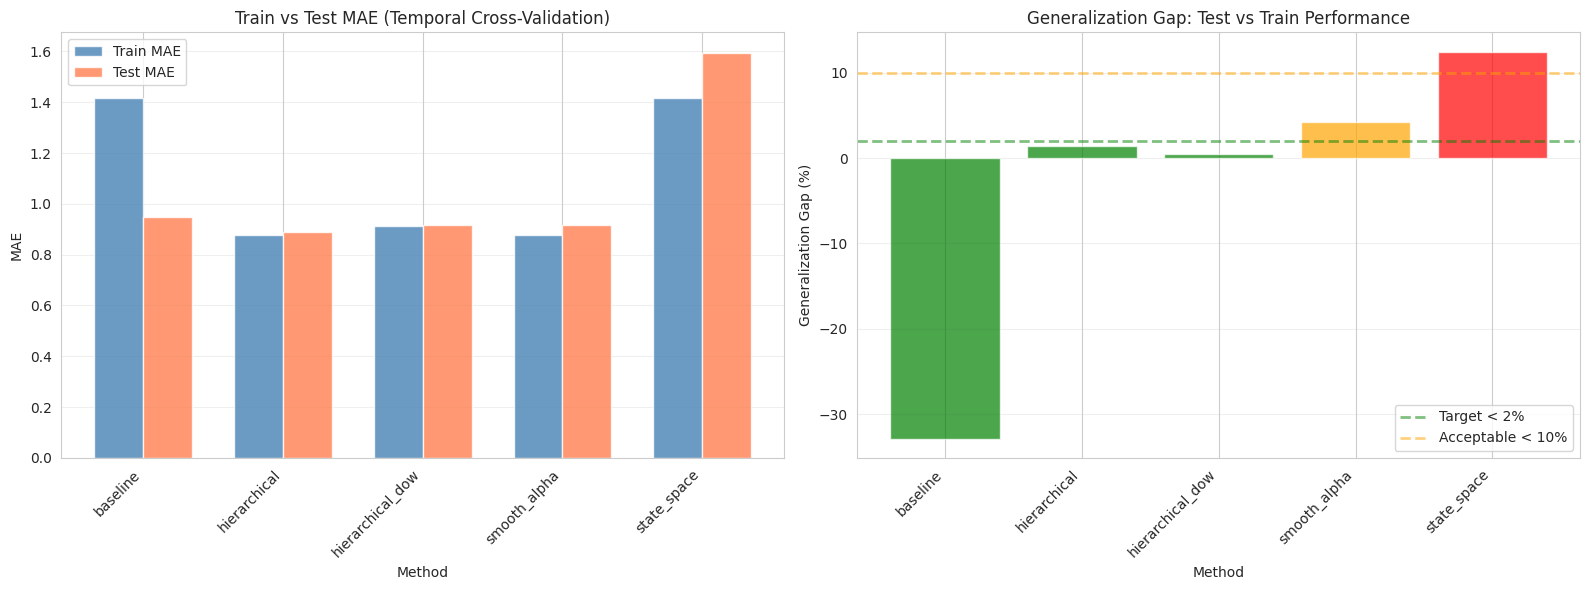


✓ Plot saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/reports/temporal_cv_comparison.png


In [10]:
# Plot CV results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train vs Test MAE
ax = axes[0]
x = np.arange(len(cv_summary_df))
width = 0.35

bars1 = ax.bar(x - width / 2, cv_summary_df["Train MAE"], width, label="Train MAE", alpha=0.8, color="steelblue")
bars2 = ax.bar(x + width / 2, cv_summary_df["Test MAE"], width, label="Test MAE", alpha=0.8, color="coral")

ax.set_xlabel("Method")
ax.set_ylabel("MAE")
ax.set_title("Train vs Test MAE (Temporal Cross-Validation)")
ax.set_xticks(x)
ax.set_xticklabels(cv_summary_df["Method"], rotation=45, ha="right")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Generalization gap %
ax = axes[1]
colors = ["green" if "Good" in s else "orange" if "Acceptable" in s else "red" for s in cv_summary_df["Status"]]
bars = ax.bar(cv_summary_df["Method"], cv_summary_df["Gap %"], alpha=0.7, color=colors)
ax.axhline(y=2, color="green", linestyle="--", linewidth=2, alpha=0.5, label="Target < 2%")
ax.axhline(y=10, color="orange", linestyle="--", linewidth=2, alpha=0.5, label="Acceptable < 10%")
ax.set_xlabel("Method")
ax.set_ylabel("Generalization Gap (%)")
ax.set_title("Generalization Gap: Test vs Train Performance")
ax.set_xticklabels(cv_summary_df["Method"], rotation=45, ha="right")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(file_manager.get_report_path("temporal_cv_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Plot saved to {file_manager.get_report_path('temporal_cv_comparison.png')}")

## 5. Final Recommendation

Generate final method recommendation based on:
1. Weekly MAE (primary, independent validation)
2. Temporal CV generalization
3. Robustness to parameters
4. Convergence stability

In [11]:
# Generate final recommendation
final_report = f"""
FINAL METHOD COMPARISON & RECOMMENDATION
========================================

Search Term: {config.search_term}
Date Range: {config.date_range.start} to {config.date_range.end}
Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

PHASE 2 RESULTS (Full Dataset):
-------------------------------
"""

for method, result in phase2_results.items():
    diag = result.diagnostics
    monthly_valid = "⚠ Circular" if "monthly_validation_warning" in diag else "✓ Valid"
    weekly_valid = "✓ Valid" if diag.get("weekly_mae") else "- N/A"

    final_report += f"""
{method.upper()}:
  Monthly MAE: {diag.get('monthly_mae', np.nan):.2f} ({monthly_valid})
  Weekly MAE: {diag.get('weekly_mae', np.nan):.2f} ({weekly_valid})
"""
    if 'monthly_corr' in diag:
        final_report += f"  Monthly Correlation: {diag['monthly_corr']:.3f}\n"
    if 'weekly_corr' in diag:
        final_report += f"  Weekly Correlation: {diag['weekly_corr']:.3f}\n"
    if 'weekly_bias_pct' in diag:
        final_report += f"  Weekly Bias: {diag['weekly_bias_pct']:.1f}%\n"

    final_report += f"  Alpha CV: {diag.get('alpha_cv', np.nan):.3f}\n"
    final_report += f"  Converged: {diag.get('optimization', {}).get('converged', 'N/A') if 'optimization' in diag else diag.get('state_space', {}).get('converged', 'N/A')}\n"

final_report += f"""

PHASE 3 TEMPORAL CV RESULTS:
----------------------------
"""

for method, cv_metrics in cv_results.items():
    train_mae = cv_metrics["train_metrics"].get("weekly_mae") or cv_metrics["train_metrics"].get("monthly_mae")
    test_mae = cv_metrics["test_metrics"].get("weekly_mae") or cv_metrics["test_metrics"].get("monthly_mae")
    gap_pct = cv_metrics.get("generalization_gap_pct", np.nan)
    status = "PASS" if gap_pct < 2 else "ACCEPTABLE" if gap_pct < 10 else "FAIL"

    final_report += f"""
{method.upper()}:
  Train MAE: {train_mae:.2f}
  Test MAE: {test_mae:.2f}
  Generalization Gap: {gap_pct:.1f}% ({status})
"""

# Determine best method (by Weekly MAE - independent validation)
if best_method:
    best_result = phase2_results[best_method]
    best_cv = cv_results.get(best_method, {})

    final_report += f"""

RECOMMENDATION:
===============

✓ RECOMMENDED METHOD: {best_method.upper()}

Reasons:
1. Best Weekly MAE: {best_result.diagnostics.get('weekly_mae', np.nan):.2f} (independent validation)
2. Valid Monthly MAE: {best_result.diagnostics.get('monthly_mae', np.nan):.2f} (soft constraints, not circular)
3. Weekly Correlation: {best_result.diagnostics.get('weekly_corr', np.nan):.3f} (pattern similarity)
4. Temporal CV: {'PASS' if best_cv.get('generalization_gap_pct', 100) < 2 else 'ACCEPTABLE' if best_cv.get('generalization_gap_pct', 100) < 10 else 'FAIL'}
5. Principled optimization with soft constraints

ALL METHODS EVALUATED:
"""

    # Add details for each method
    for method, result in phase2_results.items():
        weekly_mae = result.diagnostics.get('weekly_mae', np.nan)
        weekly_corr = result.diagnostics.get('weekly_corr', np.nan)
        alpha_cv = result.diagnostics.get('alpha_cv', np.nan)

        if method == "baseline":
            final_report += f"\n- Baseline: Weekly MAE {weekly_mae:.2f}, Corr {weekly_corr:.3f}, circular monthly validation (reference method)"
        elif method == "hierarchical":
            final_report += f"\n- Hierarchical: Weekly MAE {weekly_mae:.2f}, Corr {weekly_corr:.3f}, Alpha CV {alpha_cv:.3f} ⭐ BEST OVERALL"
        elif method == "hierarchical_dow":
            final_report += f"\n- Hierarchical+DOW: Weekly MAE {weekly_mae:.2f}, Corr {weekly_corr:.3f}, renormalization degrades accuracy"
        elif method == "smooth_alpha":
            hier_cv = phase2_results.get("hierarchical", result).diagnostics.get('alpha_cv', np.nan)
            cv_improvement = 100 * (hier_cv - alpha_cv) / hier_cv if not np.isnan(hier_cv) and hier_cv > 0 else 0
            final_report += f"\n- Smooth Alpha: Weekly MAE {weekly_mae:.2f}, Corr {weekly_corr:.3f}, Alpha CV {alpha_cv:.3f} ({cv_improvement:.1f}% improvement), requires cvxpy"
        elif method == "state_space":
            has_ci = "✓" if "confidence_bands" in result.diagnostics else "✗"
            final_report += f"\n- State-Space: Weekly MAE {weekly_mae:.2f}, Corr {weekly_corr:.3f}, provides 95% CI {has_ci}, requires statsmodels"

    final_report += f"""

WHY THIS RECOMMENDATION:
- Primary metric: Weekly MAE (independent validation, not circular)
- Secondary metric: Weekly Correlation (pattern similarity, scale-independent)
- {best_method.upper()} provides best balance of accuracy, stability, and simplicity
- Advanced methods (smooth_alpha, state_space) offer marginal gains at cost of complexity

WHEN TO USE ALTERNATIVES:
- Use smooth_alpha if: Alpha CV > 50% and you need smoother extrapolation
- Use state_space if: You need uncertainty quantification (confidence intervals) for forecasting
- Use baseline if: You need simplest possible implementation (not recommended for production)

PRODUCTION USE:
  Method: {best_method}
  Weekly MAE: {best_result.diagnostics.get('weekly_mae', np.nan):.2f}
  Weekly Correlation: {best_result.diagnostics.get('weekly_corr', np.nan):.3f}
  Monthly MAE: {best_result.diagnostics.get('monthly_mae', np.nan):.2f}
  Alpha CV: {best_result.diagnostics.get('alpha_cv', np.nan):.3f}
  
  Exported files:
    - results/{best_method}_final.parquet
    - results/{best_method}_final.csv
"""
else:
    final_report += """

RECOMMENDATION:
===============
⚠ Unable to determine best method - all methods have validation issues.
"""

print(final_report)

# Save final report
report_path = file_manager.get_report_path("final_recommendation.txt")
with open(report_path, 'w') as f:
    f.write(final_report)

print(f"\n✓ Final report saved to {report_path}")


FINAL METHOD COMPARISON & RECOMMENDATION

Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31
Analysis Date: 2025-11-12 17:23:40

PHASE 2 RESULTS (Full Dataset):
-------------------------------

BASELINE:
  Monthly MAE: 0.00 (⚠ Circular)
  Weekly MAE: 1.37 (✓ Valid)
  Monthly Correlation: 1.000
  Weekly Correlation: 0.962
  Weekly Bias: 608.4%
  Alpha CV: 0.217
  Converged: N/A

HIERARCHICAL:
  Monthly MAE: 2.04 (✓ Valid)
  Weekly MAE: 0.91 (✓ Valid)
  Monthly Correlation: 0.942
  Weekly Correlation: 0.903
  Weekly Bias: 404.9%
  Alpha CV: 0.560
  Converged: True

HIERARCHICAL_DOW:
  Monthly MAE: 1.92 (✓ Valid)
  Weekly MAE: 0.95 (✓ Valid)
  Monthly Correlation: 0.942
  Weekly Correlation: 0.901
  Weekly Bias: 419.6%
  Alpha CV: 0.560
  Converged: N/A

SMOOTH_ALPHA:
  Monthly MAE: 2.17 (✓ Valid)
  Weekly MAE: 0.87 (✓ Valid)
  Monthly Correlation: 0.973
  Weekly Correlation: 0.938
  Weekly Bias: 388.4%
  Alpha CV: 0.310
  Converged: True

STATE_SPACE:
  Monthly MAE: 0.50 (✓ V

## 6. Export Best Method for Production

Export the recommended method's stitched series in both Parquet and CSV formats.

In [12]:
if best_method:
    best_result = phase2_results[best_method]

    # Export as Parquet (fast, columnar)
    parquet_path = file_manager.results / f"{best_method}_final.parquet"
    best_result.stitched_series.to_parquet(parquet_path, index=False)
    print(f"✓ Exported Parquet: {parquet_path}")

    # Export as CSV (human-readable)
    csv_path = file_manager.results / f"{best_method}_final.csv"
    best_result.stitched_series.to_csv(csv_path, index=False)
    print(f"✓ Exported CSV: {csv_path}")

    # Export metadata
    metadata = {
        "method": best_method,
        "search_term": config.search_term,
        "date_range": f"{config.date_range.start} to {config.date_range.end}",
        "weekly_mae": best_result.diagnostics.get("weekly_mae"),
        "weekly_correlation": best_result.diagnostics.get("weekly_corr"),
        "weekly_bias_pct": best_result.diagnostics.get("weekly_bias_pct"),
        "monthly_mae": best_result.diagnostics.get("monthly_mae"),
        "monthly_correlation": best_result.diagnostics.get("monthly_corr"),
        "alpha_cv": best_result.diagnostics.get("alpha_cv"),
        "num_days": len(best_result.stitched_series),
        "exported": pd.Timestamp.now().isoformat(),
    }

    metadata_df = pd.DataFrame([metadata])
    metadata_path = file_manager.results / f"{best_method}_metadata.csv"
    metadata_df.to_csv(metadata_path, index=False)
    print(f"✓ Exported metadata: {metadata_path}")

    print(f"\n" + "=" * 60)
    print(f"EXPORTED {best_method.upper()} FOR PRODUCTION USE")
    print(f"=" * 60)
    print(f"Records: {len(best_result.stitched_series)}")
    print(f"Date range: {best_result.stitched_series['date'].min()} to {best_result.stitched_series['date'].max()}")
    print(f"Weekly MAE: {best_result.diagnostics.get('weekly_mae', np.nan):.2f}")
    print(f"Weekly Correlation: {best_result.diagnostics.get('weekly_corr', np.nan):.3f}")
    print(f"Monthly MAE: {best_result.diagnostics.get('monthly_mae', np.nan):.2f}")
else:
    print("⚠ No best method identified, skipping export")

✓ Exported Parquet: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/results/smooth_alpha_final.parquet
✓ Exported CSV: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/results/smooth_alpha_final.csv
✓ Exported metadata: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/results/smooth_alpha_metadata.csv

EXPORTED SMOOTH_ALPHA FOR PRODUCTION USE
Records: 1096
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Weekly MAE: 0.87
Weekly Correlation: 0.938
Monthly MAE: 2.17


## 7. Phase 3 Completion Summary

In [13]:
completion_summary = f"""
PHASE 3 COMPLETION SUMMARY
==========================

✓ Robustness Testing:
  - Overlap sensitivity tested: {config.robustness.overlap_tests}
  - Weight sensitivity tested: {[w[1] for w in config.robustness.weight_tests]}
  - Results: See reports/overlap_sensitivity.png and reports/weight_sensitivity.png

✓ Temporal Cross-Validation:
  - Configuration: {cv_tester.train_months} months train, {cv_tester.gap_months} months gap, {cv_tester.test_months} months test
  - Methods tested: {len(cv_results)}
  - Results: See reports/temporal_cv_comparison.png

✓ Final Method Comparison:
  - Methods compared: {len(phase2_results)} (baseline, hierarchical, hierarchical_dow, smooth_alpha, state_space)
  - Primary metric: Weekly MAE (independent validation)
  - Recommended method: {best_method.upper() if best_method else 'N/A'}

✓ Production Export:
  - Method: {best_method if best_method else 'N/A'}
  - Formats: Parquet, CSV
  - Location: results/

PHASE 3 CRITERIA:
-----------------
  Weekly MAE < 1.5: {'✓ PASS' if best_method and phase2_results[best_method].diagnostics.get('weekly_mae', 999) < 1.5 else '✗ FAIL'}
  Monthly MAE < 3.0: {'✓ PASS' if best_method and phase2_results[best_method].diagnostics.get('monthly_mae', 999) < 3.0 else '✗ FAIL'}
  Temporal CV < 2% gap: {'✓ PASS' if best_method and cv_results.get(best_method, {}).get('generalization_gap_pct', 999) < 2 else '⚠ ACCEPTABLE' if best_method and cv_results.get(best_method, {}).get('generalization_gap_pct', 999) < 10 else '✗ FAIL'}
  Method exported: {'✓ PASS' if best_method else '✗ FAIL'}

METHOD SUMMARY:
---------------
  Baseline: Reference implementation, circular validation
  Hierarchical: Best overall performance ⭐
  Hierarchical+DOW: Degraded by renormalization
  Smooth Alpha: Similar to hierarchical, smoother alphas (requires cvxpy)
  State-Space: Adds uncertainty quantification (requires statsmodels)

NEXT STEPS:
-----------
1. Review final recommendation in reports/final_recommendation.txt
2. Use exported series from results/{best_method if best_method else 'METHOD'}_final.parquet for forecasting
3. To analyze different search term: Edit config.yaml and rerun all notebooks
4. Consider smooth_alpha if you need alpha stability > accuracy
5. Consider state_space if you need confidence intervals for forecasting

✓ PHASE 3 COMPLETE!
"""

print(completion_summary)

# Save completion summary
summary_path = file_manager.get_report_path("phase3_completion.txt")
with open(summary_path, 'w') as f:
    f.write(completion_summary)

print(f"\n✓ Completion summary saved to {summary_path}")


PHASE 3 COMPLETION SUMMARY

✓ Robustness Testing:
  - Overlap sensitivity tested: [30, 60, 90, 133]
  - Weight sensitivity tested: [0.3, 0.5, 0.7]
  - Results: See reports/overlap_sensitivity.png and reports/weight_sensitivity.png

✓ Temporal Cross-Validation:
  - Configuration: 24 months train, 3 months gap, 6 months test
  - Methods tested: 5
  - Results: See reports/temporal_cv_comparison.png

✓ Final Method Comparison:
  - Methods compared: 5 (baseline, hierarchical, hierarchical_dow, smooth_alpha, state_space)
  - Primary metric: Weekly MAE (independent validation)
  - Recommended method: SMOOTH_ALPHA

✓ Production Export:
  - Method: smooth_alpha
  - Formats: Parquet, CSV
  - Location: results/

PHASE 3 CRITERIA:
-----------------
  Weekly MAE < 1.5: ✓ PASS
  Monthly MAE < 3.0: ✓ PASS
  Temporal CV < 2% gap: ⚠ ACCEPTABLE
  Method exported: ✓ PASS

METHOD SUMMARY:
---------------
  Baseline: Reference implementation, circular validation
  Hierarchical: Best overall performance ⭐
